In [ ]:
from scipy.stats import lognorm, poisson, norm
from scipy.optimize import newton, bisect
import scipy.integrate as integrate
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

In [62]:
def bid(CURRENT_PRICE, ACTIVE_BIDDERS, INCREMENT, HISTORY):
    if len(ACTIVE_BIDDERS) < 2:
        return HISTORY
    else:
        POSSIBLE_BIDDERS = ACTIVE_BIDDERS[:]
        if HISTORY:
            POSSIBLE_BIDDERS.remove(HISTORY[-1]["bidder"])
        bidder = POSSIBLE_BIDDERS[np.random.randint(len(POSSIBLE_BIDDERS))]
        if bidder < CURRENT_PRICE + INCREMENT:
            ACTIVE_BIDDERS.remove(bidder)
            return bid(CURRENT_PRICE, ACTIVE_BIDDERS, INCREMENT, HISTORY)
        else:
            HISTORY.append({
                "bidder": bidder,
                "bid": CURRENT_PRICE + INCREMENT
            })
            return bid(CURRENT_PRICE + INCREMENT, ACTIVE_BIDDERS, INCREMENT, HISTORY)
        
        
def simulate(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_DISTRIBUTION, INCREMENT, SILENT=1):
    N = ENTRY_DISTRIBUTION()
    BIDDERS = list(VALUE_DISTRIBUTION(size=N))
    BIDDERS = [round(bidder, 2) for bidder in BIDDERS]
    
    result = bid(STARTING_PRICE, BIDDERS, INCREMENT, [])
    
    recorded_bids = {}
    for b in result:
        recorded_bids[b["bidder"]] = b["bid"]
        recorded_bids = dict(sorted(recorded_bids.items(), key=lambda item: item[1]))
    
    if not SILENT:
        print("The auction has ended.")
        print(f"There were {N} potential bidders, and {len(recorded_bids)} of them submitted bids.")
        print(f"{len(result)} rounds of bidding occured.")
        print(f"From a reserve price of {STARTING_PRICE}, the recorded bids are as follows:")

        for bidder, _bid in recorded_bids.items():
            print(f"The final bid of {bidder} is {_bid}.")

    return list(recorded_bids.values())

def simulate_theoretical(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_DISTRIBUTION, INCREMENT, SILENT=1):
    N = ENTRY_DISTRIBUTION()
    BIDDERS = list(VALUE_DISTRIBUTION(size=N))
    BIDDERS = [round(bidder, 2) for bidder in BIDDERS]
    
    return BIDDERS


def phi(H, i, n):
    return bisect(lambda x: H - (\
           (math.factorial(n)/(math.factorial(n-i)*math.factorial(i-1))) \
           *integrate.quad(lambda s: s**(i-1)*(1-s)**(n-i), 0, x)[0]), 0, 1)

In [ ]:
def upper_bound(obs, _min, _max):
    EDFS = {}
    for key in obs.keys():
        for i in range(key):
            order_statistics = [l[i] for l in obs[key]]
            EDFS[f"{key}_{i+1}"] = ECDF(order_statistics)
            
    R = []

    for key, edf in EDFS.items():
        n, i = key.split("_")
        vals = []
        for j in range(_min, _max):
            try:
                vals.append(phi(edf(j/100), int(i), int(n)))
            except:
                vals.append(0)
        R.append(vals)
        
    def func(p):
        Rmin = []
        for i in range(_min, _max):
            cdfs = [l[i] for l in R]
            tot = sum([np.exp(y*p) for y in cdfs])
            val = sum([y*np.exp(y*p) for y in cdfs])/tot
            Rmin.append(val)
        return Rmin
        
    return func

In [ ]:
def lower_bound(obs, _min, _max):
    EDFS = {}
    for key in obs.keys():
        EDFS[key] = ECDF([l[-1] + INCREMENT for l in obs[key]])
    
    R = []

    for key, edf in EDFS.items():
        n = int(key)
        vals = []
        for j in range(_min, _max):
            try:
                vals.append(phi(edf(j/100), n-1, n))
            except:
                vals.append(0)
        R.append(vals)
        
    def func(p):
        Rmax = []
        for i in range(_min, _max):
            cdfs = [l[i] for l in R]
            tot = sum([np.exp(y*p) for y in cdfs])
            val = sum([y*np.exp(y*p) for y in cdfs])/tot
            Rmax.append(val)
        return Rmax
        
    return func

In [ ]:
def estimate(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, INCREMENT, AUCTION_NUM, RANGE):
    obs = {}
    for _ in range(AUCTION_NUM):
        l = simulate(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_RVS, INCREMENT)
        N = len(l)
        if N == 0:
            pass
        elif N in obs.keys():
            obs[N].append(list(l))
        else:
            obs[N] = [list(l)]
            
    _min, _max = [x*100 for x in RANGE]
            
    upper = upper_bound(obs, _min, _max)
    lower = lower_bound(obs, _min, _max)
    
    actual = []
    
    for i in range(_min, _max):
        actual.append(VALUE_CDF(i/100))

    def func(upper_p, lower_p):
        plt.plot(actual)
        plt.plot(upper(upper_p), color="green")
        plt.plot(lower(lower_p), color="red")
        
    return func

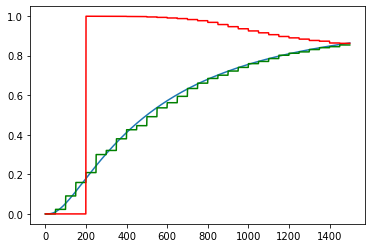

In [ ]:
STARTING_PRICE = 0
ENTRY_DISTRIBUTION = lambda: poisson.rvs(20)
VALUE_RVS = lambda size: lognorm.rvs(1, scale=5, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, 1, scale=5)
INCREMENT = 0.5
AUCTION_NUM = 500000
RANGE = [0, 15]

func = estimate(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, INCREMENT, AUCTION_NUM, RANGE)
func(2,10)

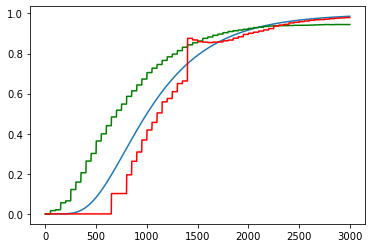

In [ ]:
STARTING_PRICE = 0
ENTRY_DISTRIBUTION = lambda: poisson.rvs(20)
VALUE_RVS = lambda size: lognorm.rvs(0.5, scale=10, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, 0.5, scale=10)
INCREMENT = 0.5
AUCTION_NUM = 500000
RANGE = [0,30]

func2 = estimate(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, INCREMENT, AUCTION_NUM, RANGE)
func2(2,10)

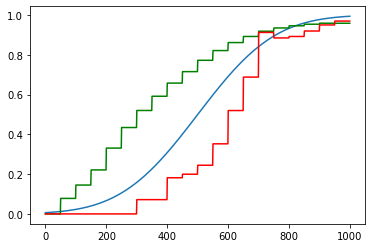

In [ ]:
STARTING_PRICE = 0
ENTRY_DISTRIBUTION = lambda: poisson.rvs(20)
VALUE_RVS = lambda size: norm.rvs(5, 2, size=size)
VALUE_CDF = lambda x: norm.cdf(x, 5, 2)
INCREMENT = 0.5
AUCTION_NUM = 500000
RANGE = [0,10]

func3 = estimate(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, INCREMENT, AUCTION_NUM, RANGE)
func3(2,10)

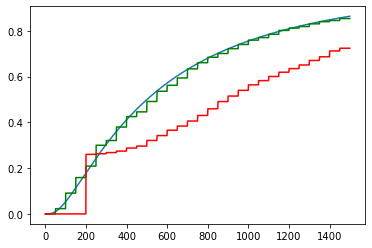

In [43]:
func(2,2)

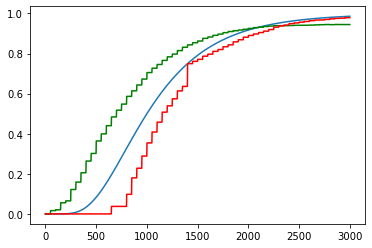

In [38]:
func2(2,5)

In [63]:
def estimate_theoretical(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, INCREMENT, AUCTION_NUM, RANGE):
    obs = {}
    for _ in range(AUCTION_NUM):
        l = simulate_theoretical(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_RVS, INCREMENT)
        N = len(l)
        if N == 0:
            pass
        elif N in obs.keys():
            obs[N].append(list(l))
        else:
            obs[N] = [list(l)]
            
    _min, _max = [x*100 for x in RANGE]
            
    upper = upper_bound(obs, _min, _max)
    lower = lower_bound(obs, _min, _max)
    
    actual = []
    
    for i in range(_min, _max):
        actual.append(VALUE_CDF(i/100))

    def func(upper_p, lower_p):
        plt.plot(actual)
        plt.plot(upper(upper_p), color="green")
        plt.plot(lower(lower_p), color="red")
        
    return func

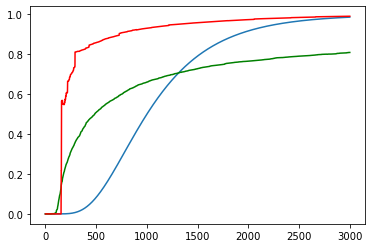

In [64]:
STARTING_PRICE = 0
ENTRY_DISTRIBUTION = lambda: poisson.rvs(20)
VALUE_RVS = lambda size: lognorm.rvs(0.5, scale=10, size=size)
VALUE_CDF = lambda x: lognorm.cdf(x, 0.5, scale=10)
INCREMENT = 0.5
AUCTION_NUM = 500000
RANGE = [0,30]

func_t = estimate_theoretical(STARTING_PRICE, ENTRY_DISTRIBUTION, VALUE_RVS, VALUE_CDF, INCREMENT, AUCTION_NUM, RANGE)
func_t(2,10)

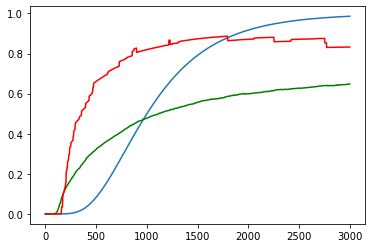

In [67]:
func_t(0,0)